   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.9 MB/s eta 0:00:00
Mounted at /content/drive
Model already trained — loading from Google Drive...
Loading saved model and classifiers...
Model ready for prediction.

Upload ZIP file with chat JSON files:


Saving Mistral.zip to Mistral.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/tmp/ipython-input-1-2092093925.py:174: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sns.heatmap(pivot.applymap(lambda x: ord(x[0]) if isinstance(x, str) else None),


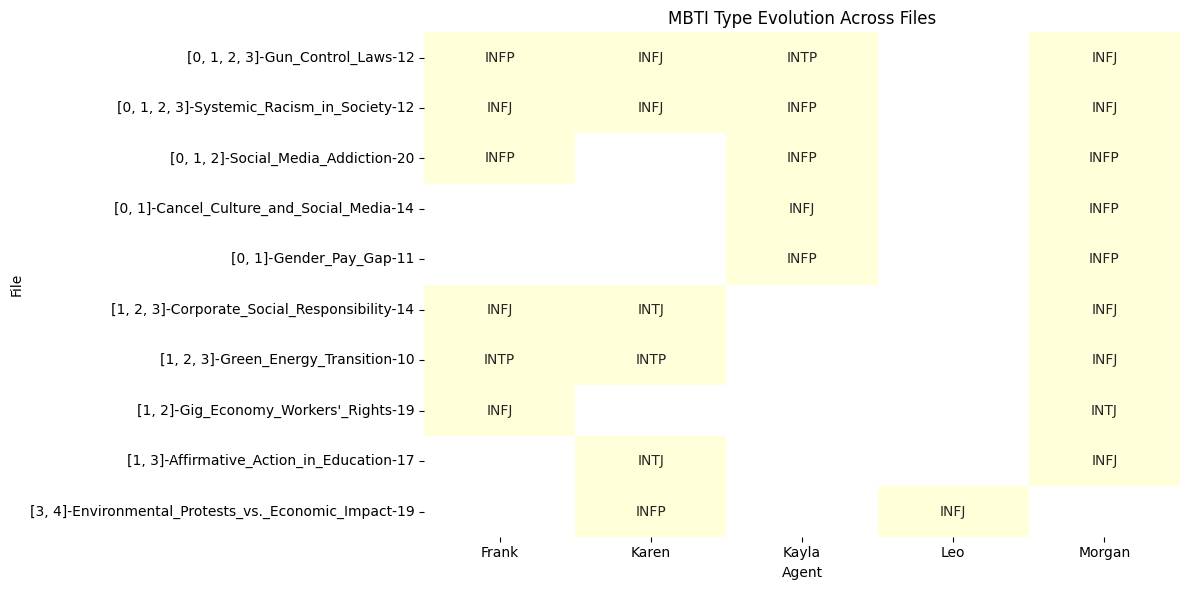

In [ ]:
!pip install -q sentence-transformers pandas scikit-learn seaborn

import os
import pickle
import json
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from google.colab import files, drive
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

drive.mount('/content/drive')
ARTIFACT_DIR = "/content/drive/MyDrive/mbti_artifacts"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

# Check if model and classifiers already exist
model_exists = os.path.exists(f"{ARTIFACT_DIR}/classifiers.pkl") and os.path.exists(f"{ARTIFACT_DIR}/sbert_model")

if not model_exists:
    print("Upload MBTI training CSV (only needed the first time):")
    uploaded = files.upload()
    train_filename = next(iter(uploaded))

    df = pd.read_csv(train_filename)
    df = df.dropna(subset=['posts', 'type'])
    df['text'] = df['posts'].apply(lambda x: " ".join(x.split("|||"))[:1000])

    def extract_traits(mbti):
        return {
            'EI': 1 if mbti[0] == 'E' else 0,
            'SN': 1 if mbti[1] == 'S' else 0,
            'TF': 1 if mbti[2] == 'T' else 0,
            'JP': 1 if mbti[3] == 'J' else 0
        }

    trait_labels = df['type'].apply(extract_traits)

    # Train model
    model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = model.encode(df['text'].tolist(), batch_size=32, show_progress_bar=True)

    classifiers = {}
    for trait in ['EI', 'SN', 'TF', 'JP']:
        y = [label[trait] for label in trait_labels]
        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(embeddings, y, test_size=0.2, random_state=42)
        clf = LogisticRegression(max_iter=1000, class_weight='balanced')
        clf.fit(X_train, y_train)
        classifiers[trait] = clf

    # Save model and classifiers
    model.save(f"{ARTIFACT_DIR}/sbert_model")
    with open(f"{ARTIFACT_DIR}/classifiers.pkl", "wb") as f:
        pickle.dump(classifiers, f)

else:
    print("Model already trained — loading from Google Drive...")
    model = SentenceTransformer(f"{ARTIFACT_DIR}/sbert_model")
    with open(f"{ARTIFACT_DIR}/classifiers.pkl", "rb") as f:
        classifiers = pickle.load(f)

if os.path.exists(f"{ARTIFACT_DIR}/classifiers.pkl") and os.path.exists(f"{ARTIFACT_DIR}/sbert_model"):
    print("Loading saved model and classifiers...")
    model = SentenceTransformer(f"{ARTIFACT_DIR}/sbert_model")
    with open(f"{ARTIFACT_DIR}/classifiers.pkl", "rb") as f:
        classifiers = pickle.load(f)
else:
    print("Training model from scratch (this will be saved for future runs)...")

    # Load and preprocess training data
    df = pd.read_csv(train_filename)
    df = df.dropna(subset=['posts', 'type'])
    df['text'] = df['posts'].apply(lambda x: " ".join(x.split("|||"))[:1000])

    def extract_traits(mbti):
        return {
            'EI': 1 if mbti[0] == 'E' else 0,
            'SN': 1 if mbti[1] == 'S' else 0,
            'TF': 1 if mbti[2] == 'T' else 0,
            'JP': 1 if mbti[3] == 'J' else 0
        }

    trait_labels = df['type'].apply(extract_traits)

    # Train Sentence Transformer + classifiers
    model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = model.encode(df['text'].tolist(), batch_size=32, show_progress_bar=True)

    classifiers = {}
    for trait in ['EI', 'SN', 'TF', 'JP']:
        y = [label[trait] for label in trait_labels]
        X_train, X_test, y_train, y_test = train_test_split(embeddings, y, test_size=0.2, random_state=42)
        clf = LogisticRegression(max_iter=1000)
        clf.fit(X_train, y_train)
        classifiers[trait] = clf

    # Save to Google Drive
    model.save(f"{ARTIFACT_DIR}/sbert_model")
    with open(f"{ARTIFACT_DIR}/classifiers.pkl", "wb") as f:
        pickle.dump(classifiers, f)

print("Model ready for prediction.")

# Upload ZIP file with JSONs
print("\nUpload ZIP file with chat JSON files:")
uploaded = files.upload()
zip_filename = next(iter(uploaded))

# Extract ZIP
extract_path = "/content/chat_json_files"
import shutil
if os.path.exists(extract_path):
    shutil.rmtree(extract_path)
os.makedirs(extract_path, exist_ok=True)
os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


# Recursively find all JSON files
json_files = []
for root, dirs, files_in_dir in os.walk(extract_path):
    for file in files_in_dir:
        if file.endswith('.json'):
            json_files.append(os.path.join(root, file))

#Prediction function
def predict_mbti(text):
    emb = model.encode([text])[0]
    mbti = ""
    for trait, clf in classifiers.items():
        pred = clf.predict([emb])[0]
        letter = trait[0] if pred == 1 else trait[1]
        mbti += letter
    return mbti

# Run predictions per agent per file
results = []
for filepath in sorted(json_files):
    filename = os.path.basename(filepath)
    with open(filepath, 'r') as f:
        chat_data = json.load(f)

    sender_messages = defaultdict(list)
    for entry in chat_data:
        sender = entry['sender']
        message = entry.get('message', '')
        sender_messages[sender].append(message)

    for sender, messages in sender_messages.items():
        combined = " ".join(messages)[:1000]
        mbti = predict_mbti(combined)
        results.append({
            'file': filename,
            'agent': sender,
            'MBTI': mbti
        })

# Save and visualize results
results_df = pd.DataFrame(results)
results_df['file_short'] = results_df['file'].apply(lambda x: os.path.splitext(x)[0])
results_df.to_csv("mbti_predictions_all.csv", index=False)
files.download("mbti_predictions_all.csv")

# Plot heatmap
pivot = results_df.pivot(index='file_short', columns='agent', values='MBTI')

plt.figure(figsize=(12, 6))
sns.heatmap(pivot.applymap(lambda x: ord(x[0]) if isinstance(x, str) else None),
            annot=pivot, fmt='', cmap='YlGnBu', cbar=False)
plt.title("MBTI Type Evolution Across Files")
plt.xlabel("Agent")
plt.ylabel("File")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()